In [26]:
# General imports
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from astropy.io import fits
from astropy.table import Table
import os
os.chdir("/Users/keith/astr/research_astr/roman_grism_sim/ultra_smooth_lambda_dependent/fits")

# Pretty plots
import matplotlib
matplotlib.rcParams["figure.figsize"] = (11,8.5)
matplotlib.rcParams["image.interpolation"] = "nearest"
matplotlib.rcParams["image.origin"] = "lower"

# Grizli
from grizli.model import GrismFLT

# pysynphot
import pysynphot as S

# WebbPSF
import webbpsf
import webbpsf.roman

import emcee
import corner

In [27]:
# Read SED template; using G0V star template
spec = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat", format="ascii")
src = S.ArraySpectrum(wave=spec["col1"], flux=spec["col2"])

# PSF
wfi = webbpsf.roman.WFI()
# webbpsf.setup_logging("Error")

eff_psf = wfi.calc_psf(monochromatic=(20000 * (10**-10)), fov_pixels=182, oversample=2, source=src)[0].data

psf_direct = np.zeros((4288, 4288))
psf_direct[(2144-182): (2144+182), (2144-182):(2144+182)] = eff_psf

In [28]:
# initialize grizli
pad = 100
roman = GrismFLT(direct_file="empty_direct.fits", seg_file="empty_seg.fits", pad=pad)

# add psf direct image and seg map
roman.direct.data["SCI"] = psf_direct.astype("float32")
roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [29]:
# set truth
spec = spec[1770:3771] # truncate spectrum to 10000-20000 angstroms

truth = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, is_cgs=True, 
                                   store=False, in_place=False, spectrum_1d=[spec["col1"], spec["col2"]])[1]
                                
truth_extraction = np.array([truth[:, ii].sum() for ii in range(truth.shape[1])])

In [30]:
def chunk(start_wave, end_wave):
    start_index = int((start_wave - 10000) / 5)
    end_index = int((end_wave - 10000) / 5)

    return spec[start_index:end_index]

In [31]:
nwalkers = 20
niter = 1000
initial = ([64, 100])
ndim = len(initial)
p0 = [np.array(initial) + 1 * np.random.randn(ndim) for i in range(nwalkers)]

chip_x = np.arange(0, truth.shape[1], 1)

np.random.seed(5)

def model(theta):
    window_extent, nbins = theta
    window_extent = int(window_extent)
    nbins = int(nbins)

    half_extent = int(window_extent / 2)

    window_x = np.linspace(-np.pi/2, np.pi/2, window_extent)
    window_y = np.cos(window_x)

    bins = np.linspace(10000, 20000, nbins + 1)

    piecemeal_sim = np.zeros((4288,4288))
    
    for ii, start_wave in enumerate(bins[:-1]):
        end_wave = bins[ii+1]

        spec_chunk = chunk(start_wave, end_wave) # extract relevant part of spetrum
        wave = spec_chunk["col1"]
        flux = spec_chunk["col2"]

        # apodize
        front_wave = window_x[0:half_extent] + wave[0]
        back_wave = window_x[half_extent:] + wave[-1]

        wave = np.append(front_wave, np.append(wave, back_wave))

        front_flux = window_y[0:half_extent] * flux[0]
        back_flux = window_y[half_extent:] * flux[-1]

        flux = np.append(front_flux, np.append(flux, back_flux))

        single_dispersion = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, is_cgs=True, store=False,
                                                       in_place=False, spectrum_1d=[wave, flux])[1]

        piecemeal_sim += single_dispersion
    
    piecemeal_extraction = np.array([piecemeal_sim[:, ii].sum() for ii in range(piecemeal_sim.shape[1])])

    return piecemeal_extraction

def lnlike(theta, x, y):
    Lnlike = -0.5 * np.sum((y - model(theta)) ** 2)
    return Lnlike

def lnprior(theta):
    extent, nbins = theta
    if 0 < extent < 1000 and 50 < nbins < 1000:
        return 0.0
    return -np.inf

def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

def main(p0, nwalkers, niter, ndim, lnprob, truth_extraction, burnin):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(chip_x, truth_extraction))

    print("Running burn in...")
    state = sampler.run_mcmc(p0, burnin)
    sampler.reset

    print("Running production...")
    sampler.run_mcmc(state, niter)

    return sampler

def plotter(sampler, truth_extraction):

    plt.plot(chip_x, truth_extraction)

    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(chip_x, model(theta), color='r', alpha=0.1)

    plt.show()

In [ ]:
sampler = main(p0, nwalkers, niter, ndim, lnprob, truth_extraction, 500)
plotter(sampler, truth_extraction)

Running burn in...


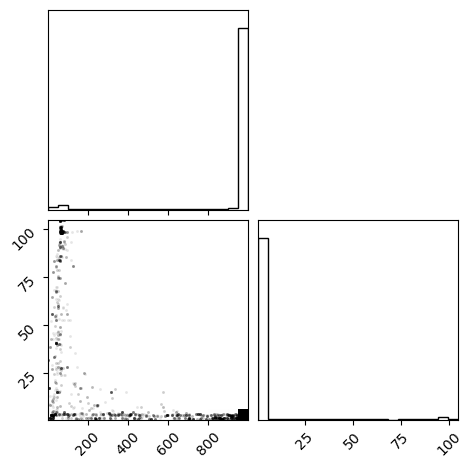

In [25]:
samples = sampler.flatchain
fig = corner.corner(samples)